### Importing libraries

In [100]:
import altair as alt #best library for visualization!
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter

#Importing Models and metrics
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Reading Data

In [2]:
df_train = pd.read_csv('train.csv')

## Analyzing Data

I am starting with `.info()` as it gives a quick glance of columns/features along with the datatype(numerical or categorical). Also, gives a headstart with the null values.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 12 features and handful of null values in `Cabin, Age`.

`.head()` shows a glimpse of dataset to get better understanding about datatype.

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`Survived, Sex, Embarked` are categorical and `Pclass` is ordinal.

`Age, Fare, SibSp, Parch` are numerical wherein first two features are continous.

`Cabin` is alphanumeric

Ignoring other features like `PassengerId, Name, Ticket` as they don't effect the outcome.(Do they??)

We can better understanding of each numerical feature with the help of `.describe()`

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


1. Total passengers count is 891.
2. Survived is categorical but in the form of binary where 1 means survived.
3. Most of the passengers belonged to third class.
4. 75% of the total passengers are below age of 38.
5. Most of the passengers travelled without siblings or spouse.
6. More than 75% passengers tarvelled without parents or childen.
7. Though more than 75% passengers paid below 31$, there are few passengers who paid as high as 512$.


### Outliers

Before we do any analysis, its better to take care of outliers as they might make our assumptions biased.

There are various strategies available to detect outliers. One of the simplest methods is Turkey method. From above `describe()` method, in `Fare` we can see that 75% of people paid 31$. But the max is 512$ which is a drastic increase and it might heavily affect our prediction if `Fare` is an important feature. Turkey method is very helpful to care of such outliers. It considers any observation below 25% and above 75% of the distribution as an outlier. We can vary 25% and 75% using outlier step.

In [6]:
def outliers(df, columns, num):
    """
    We are giving a dataframe (df_train) and specifying which columns/features it has to check for outliers
    and num represents number of outlier columns in each row to be cosidered inorder to declare a row as outlier.
    """
    outlier_idx = []
    for col in columns:
        P25 = np.percentile(df[col], 25) #25%
        P75 = np.percentile(df[col], 75) #75%
        Prange = P75 - P25 #Most values range
        outlier_step = 1.5*Prange #We  are giving a bit leniance for those just out of range
        #Will compare all all values of given column that falls outside of range and step
        list_of_idx = df[(df[col] < P25 - outlier_step) | (df[col] > P75 + outlier_step)].index
        #Will append every iteration index to a common list
        outlier_idx.extend(list_of_idx)
    #Will count no.of times each row has an outlier in its features.
    outlier_idx = Counter(outlier_idx)
    #Given num decides which rows to be removed
    final_outliers = list(i for i, c in outlier_idx.items() if c > num)

    return final_outliers

In [7]:
outliers_list = outliers(df_train, ['Age','SibSp','Parch','Fare'],2)
df_train.loc[outliers_list]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Looks like rows with very high `SibSp` (8) and `Fare` (263$) are considered outliers.

In [8]:
# df_train = df_train.drop(outliers_list)
# df_train.info()

Out of 891 entries, 10 are outliers. Remaining entries are 881.

### Plotting Analysis

Our main priority is to check which features are highly correleated with survival rate. We can do that using pivoting features or better visualized using plots.

In [9]:
df_train.groupby(['Pclass'],as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


This clearly shows survival rate is more in first and second class.

In [10]:
df_train.groupby(['Sex'],as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Almost 75% of females and less than 20% men survived.

In [11]:
df_train.groupby(['SibSp','Parch'],as_index=False)['Survived'].mean()

,SibSp,Parch,Survived
0,0,0,0.303538
1,0,1,0.657895
2,0,2,0.724138
3,0,3,1.000000
4,0,4,0.000000
5,0,5,0.000000
6,1,0,0.520325
7,1,1,0.596491
8,1,2,0.631579
9,1,3,0.333333


I can't see a clear correlation between `SibSp` and `Parch` with the survival rate. But will have a detailed look in plot.

#### Visualizing

From above tables, we can see first/second class and women has better survival rate (Nicely done Rose :) ) compared to third class and men (poor Jack '_').

What about `Age` and `Fare`?

In [12]:
#See https://altair-viz.github.io/user_guide/customization.html#customizing-colors to customize colors
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("row"),bin=alt.Bin(maxbins=20)),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    row = ['Age', 'Fare']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

The graphs are interactive and hover over the bars to view exact counts (cool!)

Better to look over the passengers who paid more than 100$

In [13]:
df_fare = df_train.loc[df_train['Fare'] > 100,:]
alt.Chart(df_fare).mark_bar().encode(
    alt.X('Fare',bin=alt.Bin(step=50)),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).interactive()

alt.Chart(...)

Seems like most of the high fare payers survived.

#### Dealing with Skewness

We we see the graphs, `Age` looks like a normal distribution but `Fare` appears to be skewed which is not desirable. There are various techniques available to reduce the skewness. If our distribution is right-skewed (positive skewness) i.e mean is larger than median, then we can use square root, cube root and logarithms. Applying log function is mostly preffered but remeber, it can't be used if the data has zero or negative values. Similarly, for left-skewed distributions, techniques like squares, cubes and higher powers can be used.  
For our case, we can apply log transformation.

In [14]:
df_train['Fare'] = df_train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [15]:
bar = alt.Chart(df_train).mark_bar().encode(
    alt.X('Fare',bin=alt.Bin(maxbins=20)),
    y = 'count()',
    color = 'Survived:N'
).interactive()
line = alt.Chart(df_train).mark_line(color = 'red').encode(
    alt.X('Fare',bin=alt.Bin(maxbins=20)),
    y = 'count()'
).interactive()
bar + line


alt.LayerChart(...)

Looks better!

In [16]:
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("column"), type = 'nominal'),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    column = ['Pclass','Sex']
).interactive()

alt.RepeatChart(...)

We can confirm `Pclass` and `Sex` clearly impact survival.

In [17]:
alt.Chart(df_train).mark_bar().encode(
    alt.X(alt.repeat("row"), type = 'nominal'),
    y = 'count()',
    color = 'Survived:N',
    tooltip = 'count()'
).repeat(
    row = ['SibSp','Parch']
).interactive()


alt.RepeatChart(...)

It is unclear, but families with less siblings/spouse have better record of surving. From `Parch`, no evident reasoning can be drawn.

In [18]:
alt.Chart(df_train).mark_bar().encode(
    x = 'Embarked',
    y = 'count()',
    color = 'Survived:N',
    tooltip = ['count()','Sex:N']
).interactive()

alt.Chart(...)

From above plots, we can say that `Pclass, Sex` and `Fare` are clearly impacting survival rate. Also, it might not be entirely clear but `Age` and `Embarked` may also be impacting survival rate. `SibSp` and `Parch` features maybe not much useful features but as our dataset is not very large, it wont hurt to keep them around. 
We did not talk about `Cabin` as it has a lot of null values. Trying to fill them and establishing a correlation might lead to errors. So its better to ignore this feature. So we can only include impacting 5 features to build the model.

In [19]:
df_train = df_train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Dealing with Null values

We know that `Age` is an important feature but it has a few missing values. There are different methods to fill null values. Simplest one is to fill with random values using mean and standard deviation. But a better approach would be figuring out age value using its correlation with other features.

In [20]:
alt.Chart(df_train).mark_boxplot().encode(
    alt.X(alt.repeat("column")),
    y = 'Age:Q'
).repeat(
    column = ['Sex','Pclass','Parch','SibSp']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

From above boxplots, good amount of correlations can be found. Looks like `Sex` is not influencing `Age`. But there seems to be some influence due to `PClass, Parch` and `SibSp`. A correlation matrix might give more detailed information.

`Sex` is in categorical. Inorder to check correlation, will convert it to numerical.

In [21]:
df_train['Sex'] = df_train['Sex'].map({
    'male' :0, 'female' : 1
})

In [22]:
df_train[['Age','Sex','Pclass','SibSp','Parch']].corr()

,Age,Sex,Pclass,SibSp,Parch
Age,1.000000,-0.093254,-0.369226,-0.308247,-0.189119
Sex,-0.093254,1.000000,-0.131900,0.114631,0.245489
Pclass,-0.369226,-0.131900,1.000000,0.083081,0.018443
SibSp,-0.308247,0.114631,0.083081,1.000000,0.414838
Parch,-0.189119,0.245489,0.018443,0.414838,1.000000


Looks like `Age` is negatively correlated wih `Pclass, SibSp` and `Parch`. So I will use meadian age of similar rows according to correlated features.

In [23]:
index_NaN_age = list(df_train["Age"][df_train["Age"].isnull()].index)

for idx in index_NaN_age :
    age_med = df_train["Age"].median()
    age_pred = df_train["Age"][((df_train['SibSp'] == df_train.iloc[idx]["SibSp"]) & (df_train['Parch'] == df_train.iloc[idx]["Parch"]) & (df_train['Pclass'] == df_train.iloc[idx]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df_train['Age'].iloc[idx] = age_pred
    else :
        df_train['Age'].iloc[idx] = age_med

/tmp/ipykernel_197/2679776331.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Age'].iloc[idx] = age_pred
/tmp/ipykernel_197/2679776331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Age'].iloc[idx] = age_med


In [24]:
df_train['Age'].isnull().sum()

0

### One hot encoding

To deal with categorical values, we use one hot encoding techique. To be more precise, if the data is in numbers, our model might try to establish a relation between the data by treating numbers as some order of relation. This might be helpful in many cases, but not if those numbers represent categories. This is mainly done using `ColumnTranformer()` or `OneHotEncoder` from sklearn or `get_dummies()` form pandas. Column transformer can come handy in cases like when you need to deal with data in the future and it can handle exceptions neatly but it returns the data as an array. Which means, we will loose the column names and is diificult to verify. So instead we will go with `get_dummies()`.

In our data, only `Embarked` needs to be dealt as it has categrical data. Though other columns has categorical data, it is in the form of 1's and 0's (less than 2 categories) which doesn't create an issue.

In [25]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix = 'Em') #Prefix to decrease the name length
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,0,3,0,22.0,1,0,1.981001,0,0,1
1,1,1,1,38.0,1,0,4.266662,1,0,0
2,1,3,1,26.0,0,0,2.070022,0,0,1
3,1,1,1,35.0,1,0,3.972177,0,0,1
4,0,3,0,35.0,0,0,2.085672,0,0,1


## Building Models

Our dataset is almost ready to be used to build a ML model. We will split the features and output.

In [26]:
X_train = df_train.drop('Survived', axis=1)
Y_train = df_train['Survived']
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,3,0,22.0,1,0,1.981001,0,0,1
1,1,1,38.0,1,0,4.266662,1,0,0
2,3,1,26.0,0,0,2.070022,0,0,1
3,1,1,35.0,1,0,3.972177,0,0,1
4,3,0,35.0,0,0,2.085672,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,2.564949,0,0,1
887,1,1,19.0,0,0,3.401197,0,0,1
888,3,1,13.5,1,2,3.154870,0,0,1
889,1,0,26.0,0,0,3.401197,1,0,0


What model to choose?  
We have data and we need to predict whether a passenger survived or not which is nothing but a classification in supervised learning environment.

### Logistic Regression

It is one of the simplest models in machine learning. Its always good to start with a simple model as we often desire simpler models over complex models.

In [27]:
mod_log = LogisticRegression(max_iter=1000)
mod_log = mod_log.fit(X_train, Y_train)
Y_pred = mod_log.predict(X_train)
accuracy_score(Y_train, Y_pred)

0.8002244668911336

We are using the same train set for training and predicting. We can understand our model performance using cross validation.

In general, k-fold cross validation splits the train and validation sets randomly but sometimes it may lead to poor train set. So insead we will use stratified k-fold.

In [28]:
kfold = StratifiedKFold(n_splits=10)

In [29]:
mod_log = LogisticRegression(max_iter=1000)
scores = cross_val_score(mod_log, X_train, Y_train,cv = kfold)
pd.DataFrame(scores)

,0
0,0.788889
1,0.797753
2,0.752809
3,0.842697
4,0.786517
5,0.764045
6,0.786517
7,0.786517
8,0.775281
9,0.820225


In [30]:
scores.mean()

0.7901248439450687

The scores above are accuracy scores. But depending on the application, we might need other performance metrics.

In [31]:
mod_log = LogisticRegression(max_iter=1000)
log_scores = cross_validate(
    mod_log, X_train, Y_train,cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
    )
mod_log_scores = pd.DataFrame(log_scores)
mod_log_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.032442,0.003438,0.788889,0.750000,0.685714,0.716418
1,0.031769,0.003148,0.797753,0.735294,0.735294,0.735294
2,0.022699,0.003278,0.752809,0.730769,0.558824,0.633333
3,0.046270,0.005641,0.842697,0.777778,0.823529,0.800000
4,0.084696,0.004130,0.786517,0.682927,0.823529,0.746667
5,0.043998,0.004436,0.764045,0.709677,0.647059,0.676923
6,0.026272,0.003461,0.786517,0.758621,0.647059,0.698413
7,0.025445,0.006130,0.786517,0.758621,0.647059,0.698413
8,0.037929,0.003282,0.775281,0.718750,0.676471,0.696970
9,0.039189,0.007356,0.820225,0.787879,0.742857,0.764706


In [32]:
print(f"Mean of accuracy is {mod_log_scores['test_Accuracy'].mean()} with a deviation of {mod_log_scores['test_Accuracy'].std()}")
print(f"Mean of f1-score is {mod_log_scores['test_F1-score'].mean()} with a deviation of {mod_log_scores['test_F1-score'].std()}")

Mean of accuracy is 0.7901248439450687 with a deviation of 0.025951960417775678
Mean of f1-score is 0.7167136081165932 with a deviation of 0.04723183385329963


### K Nearest Neighbors

KNN is one of the best and simple models for classification and pattern recognition. As the name says, it predicts the output based on the features neighbors outputs.

In [33]:
mod_knn = KNeighborsClassifier()
knn_scores = cross_validate(
    mod_knn, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_knn_scores = pd.DataFrame(knn_scores)
mod_knn_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.001964,0.004570,0.777778,0.777778,0.600000,0.677419
1,0.001850,0.004551,0.752809,0.730769,0.558824,0.633333
2,0.001833,0.004516,0.707865,0.653846,0.500000,0.566667
3,0.001664,0.003919,0.797753,0.735294,0.735294,0.735294
4,0.001642,0.005344,0.775281,0.718750,0.676471,0.696970
5,0.002140,0.005340,0.719101,0.680000,0.500000,0.576271
6,0.001925,0.004616,0.820225,0.800000,0.705882,0.750000
7,0.001945,0.004256,0.797753,0.722222,0.764706,0.742857
8,0.001812,0.004652,0.797753,0.735294,0.735294,0.735294
9,0.001703,0.004128,0.786517,0.766667,0.657143,0.707692


In [34]:
mod_knn_scores['test_Accuracy'].mean()

0.7732833957553058

There is a mistake with the way we approached KNN. Since KNN is a distance based algorithm its better to bring all the features to the same scale. This should give us better results.
Scaling can be done through preprocessing methods available in sklearn. Standard scaler is scaling with standard mean and deviation. We if need more robust scaling, Quantile Transformer is also good. It does good job in dealing outliers too.

In [35]:
X_train_scaled = StandardScaler().fit_transform(X_train)
pd.DataFrame(X_train_scaled, columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',	'Em_C',	'Em_Q',	'Em_S'])

,Pclass,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,0.827377,-0.737695,-0.545734,0.432793,-0.473674,-0.910717,-0.482043,-0.307562,0.619306
1,-1.566107,1.355574,0.655962,0.432793,-0.473674,1.369616,2.074505,-0.307562,-1.614710
2,0.827377,1.355574,-0.245310,-0.474545,-0.473674,-0.821904,-0.482043,-0.307562,0.619306
3,-1.566107,1.355574,0.430644,0.432793,-0.473674,1.075818,-0.482043,-0.307562,0.619306
4,0.827377,-0.737695,0.430644,-0.474545,-0.473674,-0.806291,-0.482043,-0.307562,0.619306
...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.737695,-0.170204,-0.474545,-0.473674,-0.328130,-0.482043,-0.307562,0.619306
887,-1.566107,1.355574,-0.771053,-0.474545,-0.473674,0.506169,-0.482043,-0.307562,0.619306
888,0.827377,1.355574,-1.184136,0.432793,2.008933,0.260416,-0.482043,-0.307562,0.619306
889,-1.566107,-0.737695,-0.245310,-0.474545,-0.473674,0.506169,2.074505,-0.307562,-1.614710


In [36]:
mod_knn = KNeighborsClassifier()
knn_scores = cross_validate(
    mod_knn, X_train_scaled, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_knn_scores = pd.DataFrame(knn_scores)
mod_knn_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.000925,0.006060,0.755556,0.685714,0.685714,0.685714
1,0.000907,0.004438,0.842697,0.833333,0.735294,0.781250
2,0.000880,0.004114,0.741573,0.739130,0.500000,0.596491
3,0.000829,0.003609,0.820225,0.714286,0.882353,0.789474
4,0.000868,0.003773,0.797753,0.722222,0.764706,0.742857
5,0.000806,0.004031,0.820225,0.821429,0.676471,0.741935
6,0.000855,0.003394,0.820225,0.800000,0.705882,0.750000
7,0.000755,0.003395,0.775281,0.750000,0.617647,0.677419
8,0.000808,0.007102,0.786517,0.714286,0.735294,0.724638
9,0.000864,0.003547,0.820225,0.827586,0.685714,0.750000


In [37]:
mod_knn_scores['test_Accuracy'].mean()

0.7980274656679149

In [38]:
mod_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Number of neighbors can have a lot of influence on the model. In default settings, it is set to 5. But we can try different setting and this can be easily done with GridsearchCV.

I am using GridSearchCV for optimizing hyperparametrs. Though grid search serves our purpose, it is slow. Since our dataset is small, it was not an issue. Other alternatives are:
1. Random Search CV  

   Instead of running all the parameters, it selects few **random** combinations. Though this is fast, there might be a tradeoff of performance compared to Grid search.
2. Bayesian Optimization  

   This is more of an intelligent guess appraoch. It starts with a few random combinations but it chooses next set of parameters by analyzing the results from previous chosen parameters. This can be implemented using a librabry called **hyperopt**.

In [39]:
grid_knn = GridSearchCV(
    estimator = mod_knn,
    param_grid={'n_neighbors': [1,2,3,4,5,6,7,8,9,10]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_knn.fit(X_train_scaled, Y_train)
mod_knn_scores = pd.DataFrame(grid_knn.cv_results_)
mod_knn_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.000733,0.000044,0.003085,0.000224,1,{'n_neighbors': 1},0.700000,0.696629,0.707865,0.764045,...,0.720000,0.704225,0.712329,0.677419,0.656716,0.704225,0.714286,0.676433,0.039314,9
1,0.000703,0.000062,0.003000,0.000331,2,{'n_neighbors': 2},0.744444,0.741573,0.730337,0.775281,...,0.687500,0.701754,0.701754,0.690909,0.655172,0.709677,0.677966,0.661571,0.045736,10
2,0.000672,0.000111,0.002846,0.000213,3,{'n_neighbors': 3},0.722222,0.831461,0.730337,0.831461,...,0.788732,0.764706,0.800000,0.761905,0.677419,0.753623,0.787879,0.737393,0.060992,2
3,0.000685,0.000079,0.002851,0.000135,4,{'n_neighbors': 4},0.766667,0.831461,0.764045,0.820225,...,0.764706,0.761905,0.689655,0.758621,0.666667,0.733333,0.709677,0.711518,0.047383,8
4,0.000719,0.000041,0.003057,0.000094,5,{'n_neighbors': 5},0.755556,0.842697,0.741573,0.820225,...,0.789474,0.742857,0.741935,0.750000,0.677419,0.724638,0.750000,0.723978,0.054303,7
5,0.000671,0.000147,0.002952,0.000340,6,{'n_neighbors': 6},0.800000,0.808989,0.764045,0.853933,...,0.816901,0.793651,0.733333,0.771930,0.642857,0.769231,0.688525,0.725615,0.061056,6
6,0.000604,0.000049,0.002790,0.000241,7,{'n_neighbors': 7},0.800000,0.842697,0.764045,0.853933,...,0.821918,0.835821,0.781250,0.806452,0.633333,0.746269,0.764706,0.754234,0.065633,1
7,0.000556,0.000038,0.002548,0.000040,8,{'n_neighbors': 8},0.833333,0.831461,0.752809,0.853933,...,0.821918,0.843750,0.711864,0.758621,0.596491,0.750000,0.757576,0.736911,0.073589,4
8,0.000680,0.000172,0.002898,0.000265,9,{'n_neighbors': 9},0.777778,0.831461,0.752809,0.831461,...,0.800000,0.848485,0.741935,0.745763,0.620690,0.727273,0.776119,0.735247,0.066776,5
9,0.000606,0.000052,0.002769,0.000130,10,{'n_neighbors': 10},0.822222,0.853933,0.764045,0.842697,...,0.810811,0.812500,0.721311,0.745763,0.631579,0.750000,0.738462,0.737083,0.060318,3


In [40]:
#Plotting graph for better visualization
alt.Chart(mod_knn_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_line().encode(
    x = 'param_n_neighbors',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics')
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Hmm, seems like performance metrics are swinging up and down...
Because when the neighbors are even, there is a tie between decision boundaries. So its always advised to choose an odd k.

In [41]:
grid_knn = GridSearchCV(
    estimator = mod_knn,
    param_grid={'n_neighbors': [1,3,5,7,9,11,13,15]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_knn.fit(X_train_scaled, Y_train)
Y_pred = grid_knn.predict(X_train_scaled)
mod_knn_scores = pd.DataFrame(grid_knn.cv_results_)
mod_knn_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.000820,0.000077,0.003758,0.000658,1,{'n_neighbors': 1},0.700000,0.696629,0.707865,0.764045,...,0.720000,0.704225,0.712329,0.677419,0.656716,0.704225,0.714286,0.676433,0.039314,8
1,0.000723,0.000081,0.003291,0.000406,3,{'n_neighbors': 3},0.722222,0.831461,0.730337,0.831461,...,0.788732,0.764706,0.800000,0.761905,0.677419,0.753623,0.787879,0.737393,0.060992,4
2,0.000752,0.000119,0.003219,0.000467,5,{'n_neighbors': 5},0.755556,0.842697,0.741573,0.820225,...,0.789474,0.742857,0.741935,0.750000,0.677419,0.724638,0.750000,0.723978,0.054303,7
3,0.000685,0.000145,0.003167,0.000798,7,{'n_neighbors': 7},0.800000,0.842697,0.764045,0.853933,...,0.821918,0.835821,0.781250,0.806452,0.633333,0.746269,0.764706,0.754234,0.065633,1
4,0.000555,0.000022,0.002605,0.000071,9,{'n_neighbors': 9},0.777778,0.831461,0.752809,0.831461,...,0.800000,0.848485,0.741935,0.745763,0.620690,0.727273,0.776119,0.735247,0.066776,6
5,0.000585,0.000063,0.002697,0.000124,11,{'n_neighbors': 11},0.822222,0.831461,0.752809,0.842697,...,0.810811,0.812500,0.761905,0.745763,0.655172,0.735294,0.757576,0.742426,0.054963,3
6,0.000670,0.000274,0.002931,0.000305,13,{'n_neighbors': 13},0.822222,0.831461,0.752809,0.820225,...,0.789474,0.830769,0.774194,0.766667,0.631579,0.738462,0.776119,0.744469,0.060915,2
7,0.000609,0.000038,0.002997,0.000370,15,{'n_neighbors': 15},0.811111,0.831461,0.775281,0.820225,...,0.789474,0.812500,0.754098,0.758621,0.631579,0.727273,0.746269,0.736755,0.052438,5


In [42]:
grid_knn.best_params_

{'n_neighbors': 7}

In [43]:
#Plotting graph for better visualization
alt.Chart(mod_knn_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_line().encode(
    x = 'param_n_neighbors',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics')
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

We can see at neighbors = 7, accuracy is high and f1-score(which is a balance of precision and recall) is also high.

In [44]:
df_knn = mod_knn_scores.loc[3,:]
print(f"Mean of accuracy is {df_knn['mean_test_Accuracy']} with a deviation of {df_knn['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_knn['mean_test_F1-score']} with a deviation of {df_knn['std_test_F1-score']}")

Mean of accuracy is 0.8226966292134831 with a deviation of 0.03936691274360046
Mean of f1-score is 0.7542338712930381 with a deviation of 0.06563345780595786


In [45]:
#print(classification_report(Y_train, Y_pred))
#plot_confusion_matrix(mod_knn, X_train_scaled, Y_train)

### Support Vector Machine

In [91]:
mod_svm = SVC()
svm_scores = cross_validate(
    mod_svm, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_svm_scores = pd.DataFrame(svm_scores)
mod_svm_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.018119,0.004714,0.666667,0.727273,0.228571,0.347826
1,0.012881,0.004175,0.640449,0.600000,0.176471,0.272727
2,0.013216,0.005077,0.685393,0.714286,0.294118,0.416667
3,0.011723,0.003862,0.775281,0.888889,0.470588,0.615385
4,0.011336,0.003872,0.651685,0.615385,0.235294,0.340426
5,0.011953,0.003902,0.674157,0.727273,0.235294,0.355556
6,0.013057,0.003767,0.719101,0.909091,0.294118,0.444444
7,0.012725,0.003864,0.696629,0.888889,0.235294,0.372093
8,0.011843,0.004071,0.786517,1.000000,0.441176,0.612245
9,0.011846,0.003849,0.685393,0.888889,0.228571,0.363636


In [92]:
mod_svm_scores['test_Accuracy'].mean()

0.69812734082397

SVM is a distance based algorithm. So it prefers scaled data.

In [94]:
mod_svm = SVC()
svm_scores = cross_validate(
    mod_svm, X_train_scaled, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_svm_scores = pd.DataFrame(svm_scores)
mod_svm_scores['test_Accuracy'].mean()

0.8181897627965042

That's quite a jump.

In [48]:
mod_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

By default, RBF kernel is chosen. Changing kernel might give better results. We can use Gridsearch to decide best kernel.

In [49]:
grid_svm = GridSearchCV(
    estimator = mod_svm,
    param_grid={'kernel': ['linear','rbf','poly']},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_svm.fit(X_train, Y_train)
mod_svm_scores = pd.DataFrame(grid_svm.cv_results_)
mod_svm_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,1.545899,0.573261,0.002711,0.000192,linear,{'kernel': 'linear'},0.811111,0.797753,0.764045,0.842697,...,0.800000,0.742857,0.677419,0.666667,0.622951,0.730159,0.686567,0.708220,0.050041,1
1,0.012101,0.000560,0.003910,0.000490,rbf,{'kernel': 'rbf'},0.666667,0.640449,0.685393,0.775281,...,0.615385,0.340426,0.355556,0.444444,0.372093,0.612245,0.363636,0.414100,0.108742,2
2,0.012698,0.000688,0.002999,0.000241,poly,{'kernel': 'poly'},0.677778,0.651685,0.707865,0.696629,...,0.341463,0.256410,0.333333,0.363636,0.210526,0.418605,0.363636,0.315155,0.079724,3


In [50]:
grid_svm.best_index_

0

In [51]:
#Plotting graph for better visualization
alt.Chart(mod_svm_scores).transform_fold(
    ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score'],
).mark_bar().encode(
    x = 'param_kernel',
    y = alt.Y('value', type = 'quantitative', title = 'Score'),
    color = alt.Color('key', type = 'nominal', title = 'Metrics'),
    tooltip = ['mean_test_Accuracy','mean_test_Precision', 'mean_test_Recall','mean_test_F1-score']
).interactive()

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Looks like linear kernel worked better than RBF

In [52]:
df_svm = mod_svm_scores.loc[0,:]
print(f"Mean of accuracy is {df_svm['mean_test_Accuracy']} with a deviation of {df_svm['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_svm['mean_test_F1-score']} with a deviation of {df_svm['std_test_F1-score']}")

Mean of accuracy is 0.786729088639201 with a deviation of 0.028599350013463757
Mean of f1-score is 0.7082203851092008 with a deviation of 0.05004076586746738


#### Stochastic Gradient Descent Classifier

SGD is not a model. It is just an optimizer. (More explained below)

In [53]:
mod_sgd = SGDClassifier()
sgd_scores = cross_validate(
    mod_sgd, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_sgd_scores = pd.DataFrame(sgd_scores)
mod_sgd_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.003583,0.002198,0.655556,1.000000,0.114286,0.205128
1,0.002364,0.002134,0.370787,0.365854,0.882353,0.517241
2,0.003470,0.002151,0.730337,0.638889,0.676471,0.657143
3,0.003322,0.001899,0.820225,0.714286,0.882353,0.789474
4,0.002856,0.001889,0.707865,0.700000,0.411765,0.518519
5,0.002257,0.001925,0.674157,0.777778,0.205882,0.325581
6,0.003046,0.001894,0.775281,0.675000,0.794118,0.729730
7,0.002308,0.001680,0.730337,0.592593,0.941176,0.727273
8,0.002066,0.001863,0.820225,0.800000,0.705882,0.750000
9,0.002969,0.001821,0.820225,0.756757,0.800000,0.777778


In [54]:
mod_sgd_scores['test_Accuracy'].mean()

0.7104993757802747

In [55]:
mod_sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Like said before, SGD is just an optimization technique. If the `loss` parameter is set to 'log', SGD classifier is same as logistic regression with SGD optimizer (logitic has gradient descent as optimizer). If the `loss` is 'hinge', it is same as linear SVM classifier.

In [56]:
grid_sgd = GridSearchCV(
    estimator = mod_sgd,
    param_grid={'loss': ['hinge','log_loss','perceptron'], 'penalty': ['l2','l1']},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_sgd.fit(X_train, Y_train)
mod_sgd_scores = pd.DataFrame(grid_sgd.cv_results_)
mod_sgd_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_penalty,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.002915,0.000445,0.002076,0.000306,hinge,l2,"{'loss': 'hinge', 'penalty': 'l2'}",0.688889,0.752809,0.651685,...,0.781250,0.742857,0.689655,0.600000,0.736842,0.534483,0.666667,0.637899,0.147656,5
1,0.004528,0.001742,0.002153,0.000724,hinge,l1,"{'loss': 'hinge', 'penalty': 'l1'}",0.744444,0.808989,0.730337,...,0.800000,0.687500,0.716049,0.730159,0.720000,0.756757,0.718750,0.715502,0.052941,1
2,0.003603,0.000491,0.001865,0.000149,log_loss,l2,"{'loss': 'log_loss', 'penalty': 'l2'}",0.722222,0.674157,0.707865,...,0.722892,0.718750,0.666667,0.553191,0.688525,0.529915,0.105263,0.556222,0.177262,6
3,0.006855,0.002275,0.002075,0.000504,log_loss,l1,"{'loss': 'log_loss', 'penalty': 'l1'}",0.788889,0.764045,0.617978,...,0.818182,0.666667,0.732394,0.746269,0.725000,0.691358,0.620690,0.698855,0.060307,3
4,0.002512,0.000404,0.001686,0.000123,perceptron,l2,"{'loss': 'perceptron', 'penalty': 'l2'}",0.700000,0.606742,0.606742,...,0.722892,0.739726,0.400000,0.727273,0.709677,0.758621,0.698413,0.663675,0.100841,4
5,0.003622,0.000910,0.001771,0.000179,perceptron,l1,"{'loss': 'perceptron', 'penalty': 'l1'}",0.788889,0.786517,0.752809,...,0.763158,0.720000,0.722892,0.735294,0.666667,0.651163,0.718750,0.703431,0.038656,2


In [57]:
print(grid_sgd.best_index_)
grid_sgd.best_params_

1


{'loss': 'hinge', 'penalty': 'l1'}

In [58]:
df_sgd = mod_sgd_scores.loc[1,:]
print(f"Mean of accuracy is {df_sgd['mean_test_Accuracy']} with a deviation of {df_sgd['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_sgd['mean_test_F1-score']} with a deviation of {df_sgd['std_test_F1-score']}")

Mean of accuracy is 0.7811860174781522 with a deviation of 0.034222640218256876
Mean of f1-score is 0.7155023756233011 with a deviation of 0.0529406654278315


### Gaussian Naive Bayes

Like the name mentioned, this model is based on the Bayes theorem and conditional probabilities. We will look into Multinominal Naive Bayes first. Since the model is mainly used for text based classifications, will take an example of classifying a message as spam or normal. Prediction in this case is done as follows:
1. Calculate probability of getting a normal message which is given by number of times in the sample we have that output to the total number of samples. Similarly calculate probability for getting a spam message. These are called **prior probabilities**
2. Let the features be occurences of words Money, Click, Hello, Dear,..
3. From the samples, will calculate probability of getting the word Money (or Click or ..) given the message is normal and similarly calculate the same given the message is spam.
4. To do a prediction for a new sample, say Hello Money Money will calculate two probabilities as `P(Normal Message)*P(Hello|Normal)*P(Money|Normal)^2` and `P(Spam Message)*P(Hello|Spam)*P(Money|Spam)^2`. Whichever probability is higher decided the output.  
Naive Bayes considers each input word as **independent** i.e the order of occurence of the words doesn't matter. Hence called *naive*. But it works suprisingly good i.e high bias but low variance.

Now for the Gaussian Naive Bayes (features are continous unlike nominal as above), the algorithm is as follows:
1. Lets take an example of outputs being buys a ticket or doesn't buy a ticket. Let the features be distance of theatre, price of ticket,..
2. Firstly, prior porbabilites are calculated similar to above case.
2. From the samples, a gaussian distribution is plotted for every feature given buys a ticket and doesn't buy a ticket.
3. To do a prediction for a new sample, we calculate probabilities as `P(goes to movie)*P(distance=value|goes to movie)*P(price=value|goes to movie)` and `P(doesn't go to movie)*P(distance=value|doesn't go to movie)*P(price=value|doesn't go to movie)`. Except for prior probabilties, other probabilties are likelihoods calculated from gaussian distribution formula.
4. Sometimes the above probabilities are calculated in log scale to prevent underflow (if likelihood is nearly zero, the system can't represent such a small value).
5. Sometimes the model can even be used to find the most important features if the features differ a lot.

In [98]:
mod_gnb = GaussianNB()
gnb_scores = cross_validate(
    mod_gnb, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_gnb_scores = pd.DataFrame(gnb_scores)
mod_gnb_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.001571,0.001803,0.733333,0.641026,0.714286,0.675676
1,0.001099,0.001707,0.707865,0.590909,0.764706,0.666667
2,0.001107,0.001901,0.775281,0.705882,0.705882,0.705882
3,0.001477,0.010228,0.730337,0.608696,0.823529,0.700000
4,0.001444,0.001692,0.775281,0.666667,0.823529,0.736842
5,0.007301,0.003839,0.764045,0.685714,0.705882,0.695652
6,0.001373,0.002245,0.808989,0.742857,0.764706,0.753623
7,0.001111,0.001655,0.808989,0.742857,0.764706,0.753623
8,0.001041,0.002360,0.764045,0.675676,0.735294,0.704225
9,0.001065,0.001912,0.831461,0.777778,0.800000,0.788732


In [99]:
mod_gnb_scores['test_Accuracy'].mean()

0.7699625468164794

In [61]:
mod_gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

### Decision Trees

Decision trees are one of the most used algorithms in practice. Though they take time, they often give best results. Also they are one of the best to visualize what is happening inside the model.

1. Decision trees start with the root and have Nodes (decisions). Each of these nodes can again have nodes. The node without any following nodes (children) is called a leaf.
2. Each of these node decisions are decisions taken on a feature of the dataset (Hates Rose<--(left is no)loves Titanic(right is yes)-->Loves Rose). Generally the leaves are output.
3. If there are multiple features, to decide which feature goes first on the tree, following method is used (**Gini Impurity**).
    * Each feature is soley used to predict the outcome. Say the outcome is Buys ticket or doesn't buy. Feature be, Likes Actor (Yes or No). 
    * Out of all samples, number of yes and no in output is calculated for liking actor and not liking actor.
    * Which means each children (leaf) of this node will have a number of yes and no.
    * Gini Impurity for each leaf is calculated as `1-(Probability of Yes)^2-(Probability of No)^2.
    * Total gini impurity of the node is calculated by averaging impuroty on each leaf.
    * If the number of samples on each of the leaf is not equal take the weighted average of each leaf and do average for node i.e Weighted avg of each leaf = `(Number of samples in leaf/Total samples in the node)*gini impurity of the leaf`.  

    What if the feature has numeric data?  
    * Let the feature be distance of theatre. Sort that column and then calculate avergae of each of the adjacent cells and calculated gini impurity.
    * For example, let the sorted values be 7,12,18,35,38. Calulating avg of each adjacent cell gives 9.5,15,26.5,36.5.
    * Each node will be like Distance < 9.5, then each of the leaf will have outputs yes and no. Then calculate gini impurity for this node.
    * Repeat the above step for all 15,26.5,36.5 and decide the best value.
    * This best value node, Distance < 15 will compete with other features like, likes actor to be decided to go first.
4. Now we will have one feature decision as the root. If the children of this root have any impurity i.e few Yes and few No (Pure means full yes or full no), then that children will become a Node and step 3 is repeated again till we reach a node that is pure.
5. If the node is pure then it becomes a leaf.
6. If the leaf has No, then the decision is Doesn't buy ticket and vice-versa.

What if the output is a regression value?  
1. Choosing a feature is done by gini impurity but instead of taking yes and no probability, we take squared residual errors. 
2. Say distance be a feature and price be output. If distance < 3, the children will be Price = (Average outputs in data when distance is less than 3) and other children will other end average.
3. Each children gini impurity is calculated by (Average - Actual price)^2 for each sample and add all to get impurity of that leaf.
4. Thus choose a distance < value, such that value gives least residual errors.
5. Compare this way for all other features to choose root.
6. The root's children will become a leaf if there is no further reduction. This will create a leaf for each sample. To avoid this we will set a parameter ex:7 which means if a node cant avg 7 or more samples, it becomes a leaf displaying the avg value which is nothing but output.

In [62]:
mod_dc = DecisionTreeClassifier()
dc_scores = cross_validate(
    mod_dc, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_dc_scores = pd.DataFrame(dc_scores)
mod_dc_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.003099,0.002024,0.755556,0.675676,0.714286,0.694444
1,0.002016,0.002436,0.808989,0.757576,0.735294,0.746269
2,0.001989,0.001739,0.741573,0.703704,0.558824,0.622951
3,0.002481,0.001800,0.764045,0.658537,0.794118,0.720000
4,0.001970,0.001832,0.842697,0.794118,0.794118,0.794118
5,0.001831,0.001908,0.808989,0.729730,0.794118,0.760563
6,0.002183,0.001910,0.797753,0.807692,0.617647,0.700000
7,0.001894,0.002190,0.797753,0.785714,0.647059,0.709677
8,0.001974,0.001734,0.820225,0.714286,0.882353,0.789474
9,0.001834,0.001626,0.797753,0.742857,0.742857,0.742857


In [63]:
mod_dc_scores['test_Accuracy'].mean()

0.7935330836454431

We will visualize the tree to get better insights

In [64]:
mod_dc = mod_dc.fit(X_train, Y_train)

[Text(0.5315080165130568, 0.975, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not_Survived'),
 Text(0.24590773809523808, 0.925, 'Age <= 12.75\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = Not_Survived'),
 Text(0.05261136712749616, 0.875, 'SibSp <= 2.5\ngini = 0.494\nsamples = 38\nvalue = [17, 21]\nclass = Survived'),
 Text(0.04032258064516129, 0.825, 'Parch <= 0.5\ngini = 0.091\nsamples = 21\nvalue = [1, 20]\nclass = Survived'),
 Text(0.03417818740399386, 0.775, 'SibSp <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = Not_Survived'),
 Text(0.02803379416282642, 0.725, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Not_Survived'),
 Text(0.04032258064516129, 0.725, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Survived'),
 Text(0.04646697388632873, 0.775, 'gini = 0.0\nsamples = 19\nvalue = [0, 19]\nclass = Survived'),
 Text(0.06490015360983103, 0.825, 'Age <= 3.5\ngini = 0.111\nsamples = 17\nvalue = [16, 1]\nclass = Not_Survived'),
 Text(

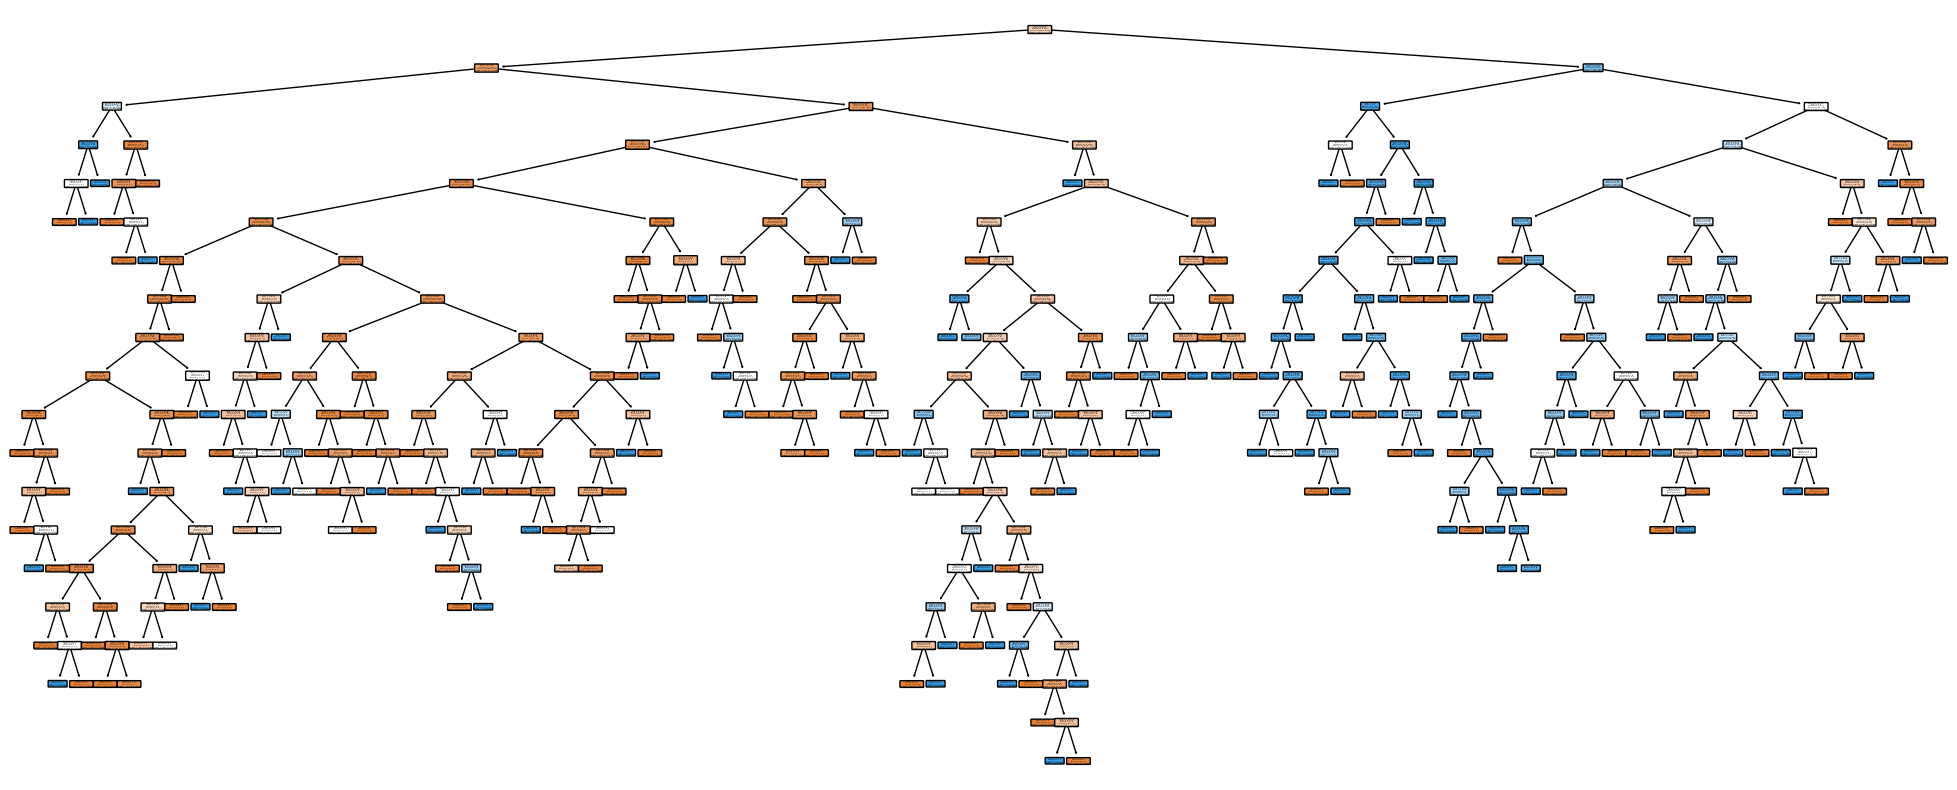

In [65]:
plt.figure(figsize=(25, 10))
plot_tree(mod_dc, 
        filled=True, 
        rounded=True, 
        class_names=['Not_Survived', 'Survived'], 
        feature_names=X_train.columns)

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


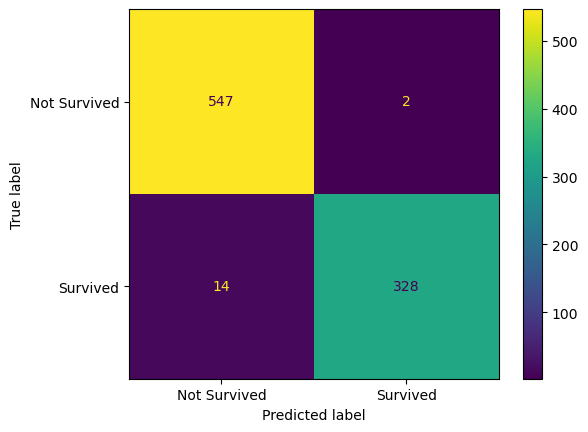

In [66]:
plot_confusion_matrix(mod_dc, X_train, Y_train, display_labels=['Not Survived', 'Survived'])

As you can see the, the tree is **huge**. The text information gives how exaclty the decions are made. But if you see the tree, there are so many decions and so many leaf nodes which might be because the model is trying to ovefit. Decision tress generally overfit and we have to prune the tree.

In [67]:
mod_dc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

There are two types of pruning. 
1. Pre-pruning technique involves tuning few above shown hyper-paramters like `max_depth`, `max_features`, `min_samples_leaf` and `min_samples_split` before training the model. This type of pre-fitting optimization is called early fitting. 

2. Other technique is called post-pruning. We typically tune only `ccp_aplha` which stands for Cost Complexity Pruning. It is similar to regularization where aplha is similar to lambda. More the value of aplha more the decion tree is pruned. In our case, we can tune this aplha using our grid search.

In [68]:
#First, we need to find available aplhas
path = mod_dc.cost_complexity_pruning_path(X_train, Y_train)
alphas = path.ccp_alphas
#Removing last value of alphas as it will remove all leaves
alphas = alphas[:-1]
alphas

array([0.00000000e+00, 0.00000000e+00, 2.04060810e-05, 3.11759571e-05,
       4.53468467e-05, 4.67639357e-05, 7.48222970e-05, 7.48222970e-05,
       1.23894063e-04, 1.30939020e-04, 2.24466891e-04, 3.24229954e-04,
       3.36700337e-04, 3.51438062e-04, 3.74111485e-04, 5.41816634e-04,
       5.58673151e-04, 6.39936195e-04, 6.41333975e-04, 6.54695099e-04,
       6.73400673e-04, 7.04209855e-04, 7.32303333e-04, 7.35541225e-04,
       7.40665163e-04, 7.48222970e-04, 7.82756338e-04, 7.83279571e-04,
       8.16243240e-04, 8.72926799e-04, 8.97867565e-04, 8.97867565e-04,
       9.20889810e-04, 9.29610357e-04, 9.62000962e-04, 9.98730955e-04,
       1.01010101e-03, 1.02880658e-03, 1.04216771e-03, 1.06888996e-03,
       1.07009774e-03, 1.07251908e-03, 1.12233446e-03, 1.12233446e-03,
       1.15186957e-03, 1.16950407e-03, 1.19715675e-03, 1.19715675e-03,
       1.19715675e-03, 1.24952911e-03, 1.30939020e-03, 1.30939020e-03,
       1.34182518e-03, 1.44300144e-03, 1.49644594e-03, 1.56446621e-03,
      

We can even try to tune `criterion` which determines how good our split is. Default is `gini` but we can also use `entropy` and `log_loss`. . But mostly `gini` is used so we will stick with that.

In [69]:
mod_dc2 = DecisionTreeClassifier()
grid_dc = GridSearchCV(
    estimator = mod_dc2,
    param_grid={'ccp_alpha': alphas},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_dc.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 2.04060810e-05, 3.11759571e-05,
       4.53468467e-05, 4.67639357e-05, 7.48222970e-05, 7.48222970e-05,
       1.23894063e-04, 1.30939020e-04, 2.24466891e-04, 3.24229954e-04,
       3.36700337e-04, 3.51438062e-...
       2.24466891e-03, 2.40421646e-03, 2.48458543e-03, 2.65565625e-03,
       2.84448495e-03, 3.13120267e-03, 3.73626008e-03, 3.76073487e-03,
       3.79003919e-03, 4.07860114e-03, 1.12809002e-02, 1.26245950e-02,
       1.44588122e-02, 3.49754571e-02])},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)})

In [70]:
print(grid_dc.best_score_)
grid_dc.best_params_

0.8227465667915107


{'ccp_alpha': 0.001636737747848859}

In [71]:
mod_dc_pruned = DecisionTreeClassifier(ccp_alpha=0.0015741833923652096)
dc_pruned_scores = cross_validate(
    mod_dc_pruned, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_dc_pruned_scores = pd.DataFrame(dc_pruned_scores)
mod_dc_pruned_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.002307,0.001884,0.788889,0.735294,0.714286,0.724638
1,0.002059,0.001681,0.842697,0.857143,0.705882,0.774194
2,0.002257,0.001728,0.741573,0.720000,0.529412,0.610169
3,0.002222,0.001744,0.808989,0.688889,0.911765,0.784810
4,0.001938,0.001681,0.865169,0.843750,0.794118,0.818182
5,0.002036,0.001771,0.820225,0.781250,0.735294,0.757576
6,0.002041,0.002867,0.820225,0.875000,0.617647,0.724138
7,0.002180,0.001783,0.797753,0.863636,0.558824,0.678571
8,0.001995,0.001656,0.887640,0.815789,0.911765,0.861111
9,0.001816,0.001640,0.831461,0.794118,0.771429,0.782609


In [72]:
mod_dc_pruned_scores['test_Accuracy'].mean()

0.8204619225967541

[Text(0.446875, 0.9666666666666667, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not_Survived'),
 Text(0.1375, 0.9, 'Age <= 12.75\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = Not_Survived'),
 Text(0.05, 0.8333333333333334, 'SibSp <= 2.5\ngini = 0.494\nsamples = 38\nvalue = [17, 21]\nclass = Survived'),
 Text(0.025, 0.7666666666666667, 'gini = 0.091\nsamples = 21\nvalue = [1, 20]\nclass = Survived'),
 Text(0.075, 0.7666666666666667, 'gini = 0.111\nsamples = 17\nvalue = [16, 1]\nclass = Not_Survived'),
 Text(0.225, 0.8333333333333334, 'Fare <= 3.268\ngini = 0.273\nsamples = 539\nvalue = [451, 88]\nclass = Not_Survived'),
 Text(0.125, 0.7666666666666667, 'Em_C <= 0.5\ngini = 0.184\nsamples = 399\nvalue = [358, 41]\nclass = Not_Survived'),
 Text(0.1, 0.7, 'gini = 0.164\nsamples = 354\nvalue = [322, 32]\nclass = Not_Survived'),
 Text(0.15, 0.7, 'Fare <= 2.718\ngini = 0.32\nsamples = 45\nvalue = [36, 9]\nclass = Not_Survived'),
 Text(0.125, 0.63333333333

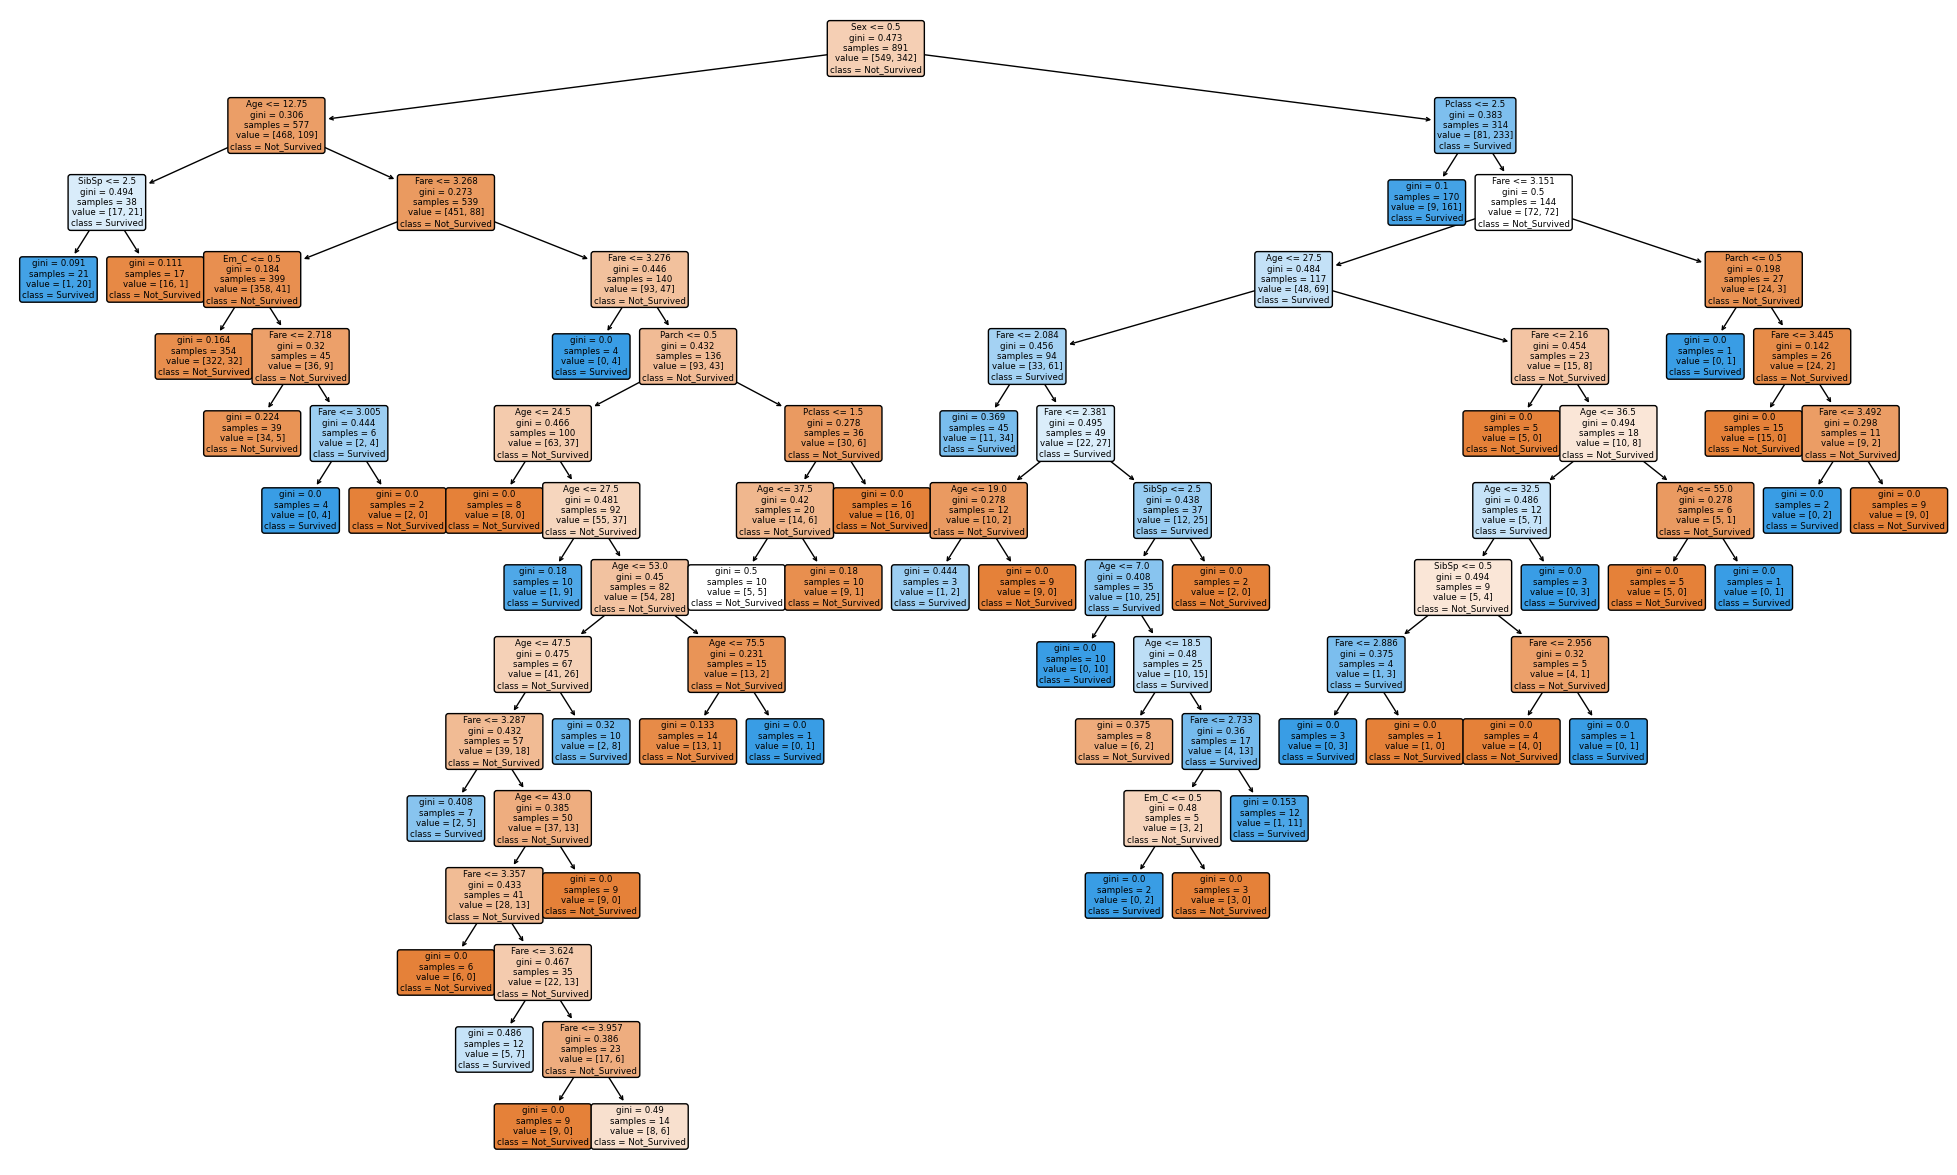

In [73]:
mod_dc_pruned = mod_dc_pruned.fit(X_train, Y_train)
plt.figure(figsize=(25, 15))
plot_tree(mod_dc_pruned, 
        filled=True, 
        rounded=True, 
        class_names=['Not_Survived', 'Survived'], 
        feature_names=X_train.columns)

As we can see, the tree is pruned and performance is at its highest.

### Ensemble Models

Ensemble methods are combinations of several base estimators. There are two types of ensemble methods:  
1. Averaging:  
    They combine several base estimators and then average their predictions to give final predictions. It is like voting with each vote carrying same power i.e each base estimator has equal effect on final output. **Reduces Variance**  
    Ex: Bagging (Mix of bagging and any other base estimator), Random Forest (Combination of Decision trees)
    
2. Bagging:  
    Base estimators are built sequentially i.e one after another. Present estimator decides the next estimator effect on final predictions. It is also voting but not all votes have equal power. The motivation is to combine several weak models to produce a powerful ensemble. **Reduces Bias**  
    Ex: AdaBoost, Gradient Tree Boosting

#### Random Forest

Decision trees are good for visualizing but not the best for performance. Random forest gives best of both worlds. Moreover we can even analyze the feature importance. Random forest algorithm involves following steps:  
1. Bootstrap the dataset (take random samples from the dataset with repetition and make another dataset with equal size as original)
2. Then choose random features to create a decision tree
3. Repeat the step 2 for n times creating a forest of trees using random features (Hence the name Random Forest).
4. Predict the output of a new sample is done through maximum similar output resulted from n trees (voting). 

In [74]:
mod_rf = RandomForestClassifier()
rf_scores = cross_validate(
    mod_rf, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_rf_scores = pd.DataFrame(rf_scores)
mod_rf_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.091896,0.006984,0.744444,0.650000,0.742857,0.693333
1,0.087995,0.006298,0.797753,0.766667,0.676471,0.718750
2,0.086603,0.006087,0.741573,0.703704,0.558824,0.622951
3,0.087051,0.006451,0.831461,0.756757,0.823529,0.788732
4,0.087341,0.006398,0.876404,0.828571,0.852941,0.840580
5,0.084245,0.006460,0.842697,0.794118,0.794118,0.794118
6,0.090677,0.006140,0.820225,0.821429,0.676471,0.741935
7,0.084733,0.006111,0.797753,0.785714,0.647059,0.709677
8,0.084935,0.006096,0.820225,0.725000,0.852941,0.783784
9,0.088190,0.007641,0.853933,0.823529,0.800000,0.811594


In [75]:
mod_rf_scores['test_Accuracy'].mean()

0.8126466916354556

In [76]:
mod_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We have many hyper-parameters that can be tuned just like in decision trees. The main difference between decision trees and random forest is the `n_estimators` which is nothing but number of decision trees.

In [77]:
grid_rf = GridSearchCV(
    estimator = mod_rf,
    param_grid={'n_estimators': [i for i in np.arange(50, 500, 50)]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_rf.fit(X_train, Y_train)
mod_rf_scores = pd.DataFrame(grid_rf.cv_results_)
mod_rf_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.044169,0.002440,0.004328,0.000259,50,{'n_estimators': 50},0.766667,0.831461,0.752809,0.808989,...,0.767123,0.869565,0.794118,0.741935,0.738462,0.800000,0.811594,0.765225,0.059919,1
1,0.089244,0.005890,0.006637,0.000740,100,{'n_estimators': 100},0.744444,0.820225,0.752809,0.831461,...,0.788732,0.840580,0.776119,0.754098,0.718750,0.828571,0.805970,0.759706,0.060518,2
2,0.128892,0.001679,0.008584,0.000582,150,{'n_estimators': 150},0.733333,0.820225,0.752809,0.820225,...,0.777778,0.840580,0.776119,0.754098,0.709677,0.805556,0.811594,0.755382,0.058706,5
3,0.177633,0.010806,0.010609,0.000451,200,{'n_estimators': 200},0.755556,0.820225,0.741573,0.820225,...,0.777778,0.845070,0.794118,0.730159,0.738462,0.794521,0.811594,0.756667,0.060745,4
4,0.220532,0.012329,0.014112,0.001736,250,{'n_estimators': 250},0.755556,0.820225,0.764045,0.831461,...,0.788732,0.845070,0.794118,0.741935,0.698413,0.805556,0.794118,0.757570,0.056303,3
5,0.260562,0.005724,0.015195,0.000772,300,{'n_estimators': 300},0.733333,0.820225,0.741573,0.820225,...,0.777778,0.823529,0.776119,0.754098,0.698413,0.783784,0.811594,0.748152,0.060135,9
6,0.303182,0.006226,0.017902,0.000453,350,{'n_estimators': 350},0.733333,0.820225,0.741573,0.808989,...,0.767123,0.840580,0.794118,0.754098,0.698413,0.794521,0.811594,0.750764,0.064835,7
7,0.344926,0.010559,0.019636,0.002059,400,{'n_estimators': 400},0.722222,0.820225,0.741573,0.831461,...,0.788732,0.840580,0.794118,0.754098,0.698413,0.773333,0.811594,0.749893,0.065891,8
8,0.390584,0.006607,0.022123,0.001110,450,{'n_estimators': 450},0.744444,0.831461,0.752809,0.820225,...,0.777778,0.816901,0.794118,0.730159,0.698413,0.805556,0.811594,0.752890,0.059643,6


In [78]:
print(grid_rf.best_index_)
grid_rf.best_params_

0


{'n_estimators': 50}

In [79]:
df_rf = mod_rf_scores.loc[1,:]
print(f"Mean of accuracy is {df_rf['mean_test_Accuracy']} with a deviation of {df_rf['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_rf['mean_test_F1-score']} with a deviation of {df_rf['std_test_F1-score']}")

Mean of accuracy is 0.8205118601747815 with a deviation of 0.04181239927026153
Mean of f1-score is 0.759706387021952 with a deviation of 0.06051782081812651


Let's see what features are important for the random forest model.

In [80]:
mod_rf.fit(X_train, Y_train)
#imp_features = pd.Series(mod_rf.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feature_scores = pd.Series(mod_rf.feature_importances_)
feature_scores

0    0.083376
1    0.270372
2    0.264996
3    0.050448
4    0.034454
5    0.259272
6    0.013782
7    0.007402
8    0.015897
dtype: float64

In [81]:
#Altair doesn't take series objects so converting into dataframe
features = pd.Series(X_train.columns)
features_df = pd.DataFrame({'features':features, 'score':feature_scores})
features_df

,features,score
0,Pclass,0.083376
1,Sex,0.270372
2,Age,0.264996
3,SibSp,0.050448
4,Parch,0.034454
5,Fare,0.259272
6,Em_C,0.013782
7,Em_Q,0.007402
8,Em_S,0.015897


In [82]:
alt.Chart(features_df).mark_bar().encode(
    alt.X('score:Q'),
    alt.Y('features:N'),
    color = 'features'
)

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Like we expected, `Sex`, `Fare` and `Age` the most important features. If we want our model to be fast and robust, we can exclude least important features for a small tradeoff on performance.

#### AdaBoost

1. The core principle of AdaBoost is to fit a sequence of weak learners on repeatedly modified versions of the data.  
2. These weak learners are many a times stumps(decision tree with only one node(leaf<--Root-->Leaf). We create forest of these stumps.  
3. Each sample is given a sample weight. Initially sample weight is equal for all sammples (1/No.of.samples).  
4. To create our first stump, out of all features, best feature is choosed as the node(similar to decision tree, Gini Index). This stump is used to predict the output. The amount of say is then calculated for the stump using `0.5*log((1-TotalError)/Total Error)`.  
5. Training samples that are incorrectly classified will now have increased sample weight and correctly classified will have decreased sample weight. Amount of increase is determined by `New Weight = sample weight * e^(amount of say)`. Similarly decrease is given by `New Weight = sample weight * e^-(amount of say)`.  
6. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.  
7. Using these new sample weights, repeat above steps again i.e create a stump, predict and calculate amount of say, ...
8. After creating all these stumps, to give the final prediction, each of predictions from a stump is weighted using respective amount of say and then the final prediction is decided.

In [101]:
mod_ada = AdaBoostClassifier()
ada_scores = cross_validate(
    mod_ada, X_train, Y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)}
)
mod_ada_scores = pd.DataFrame(ada_scores)
mod_ada_scores

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F1-score
0,0.046026,0.004658,0.766667,0.705882,0.685714,0.695652
1,0.045276,0.004792,0.775281,0.684211,0.764706,0.722222
2,0.039600,0.004374,0.752809,0.714286,0.588235,0.645161
3,0.037585,0.004566,0.820225,0.736842,0.823529,0.777778
4,0.037027,0.004259,0.831461,0.743590,0.852941,0.794521
5,0.040033,0.004574,0.808989,0.793103,0.676471,0.730159
6,0.036811,0.004398,0.831461,0.827586,0.705882,0.761905
7,0.036813,0.004360,0.831461,0.827586,0.705882,0.761905
8,0.038258,0.004650,0.831461,0.787879,0.764706,0.776119
9,0.039552,0.004342,0.831461,0.812500,0.742857,0.776119


In [103]:
mod_ada_scores['test_Accuracy'].mean()

0.80812734082397

In [104]:
mod_ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

n_estimators is the number of weak learners

In [108]:
grid_ada = GridSearchCV(
    estimator = mod_ada,
    param_grid={'n_estimators': [i for i in np.arange(10, 300, 50)]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score), 'Precision':make_scorer(precision_score), 'Recall':make_scorer(recall_score), 'F1-score':make_scorer(f1_score)},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_ada.fit(X_train, Y_train)
mod_ada_scores = pd.DataFrame(grid_ada.cv_results_)
mod_ada_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.009408,0.001117,0.002644,0.000354,10,{'n_estimators': 10},0.766667,0.775281,0.764045,0.842697,...,0.805556,0.756757,0.709677,0.718750,0.709677,0.757576,0.782609,0.730299,0.043859,6
1,0.048097,0.001826,0.005456,0.000693,60,{'n_estimators': 60},0.777778,0.775281,0.752809,0.831461,...,0.794521,0.810811,0.707692,0.750000,0.761905,0.776119,0.764706,0.743902,0.046741,4
2,0.088293,0.007738,0.007789,0.000510,110,{'n_estimators': 110},0.766667,0.775281,0.775281,0.820225,...,0.783784,0.810811,0.698413,0.769231,0.769231,0.738462,0.816901,0.747137,0.048412,3
3,0.124560,0.002553,0.010392,0.000723,160,{'n_estimators': 160},0.800000,0.752809,0.775281,0.820225,...,0.783784,0.810811,0.718750,0.769231,0.787879,0.750000,0.811594,0.754677,0.044273,1
4,0.162328,0.003674,0.012666,0.000339,210,{'n_estimators': 210},0.800000,0.752809,0.752809,0.808989,...,0.773333,0.794521,0.757576,0.769231,0.750000,0.727273,0.794118,0.743669,0.046652,5
5,0.209153,0.008254,0.016502,0.001257,260,{'n_estimators': 260},0.800000,0.752809,0.752809,0.820225,...,0.783784,0.805556,0.781250,0.793651,0.761905,0.738462,0.782609,0.751785,0.050164,2


From the bove grid, it seems like the accuracy was almost saturated even by increasing the estimators. Maybe the weak learners achieved a perfect fit and stopped by some number of tress/estimators/weak learners.

In [109]:
print(grid_ada.best_index_)
grid_ada.best_params_

5


{'n_estimators': 260}

In [110]:
df_ada = mod_ada_scores.loc[5,:]
print(f"Mean of accuracy is {df_ada['mean_test_Accuracy']} with a deviation of {df_ada['std_test_Accuracy']}")
print(f"Mean of f1-score is {df_ada['mean_test_F1-score']} with a deviation of {df_ada['std_test_F1-score']}")

Mean of accuracy is 0.8137078651685394 with a deviation of 0.034057364145198055
Mean of f1-score is 0.7517850049643527 with a deviation of 0.05016432339236012


#### Gradient Boosting